In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

import scoring as score # para hacer los reportes de puntajes
from time import time

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,IsolationForest
from sklearn.preprocessing import RobustScaler  
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

properati = pd.read_csv('datos/properati_3.csv')
#test_samples = pd.read_csv('datos/properati_dataset_testing_noprice_acondicionado.csv',error_bad_lines=False)


<IPython.core.display.Javascript object>

In [2]:
properati.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130779 entries, 0 to 130778
Data columns (total 27 columns):
id                            130779 non-null object
created_on                    130779 non-null object
operation                     130779 non-null object
property_type                 130779 non-null object
place_name                    130779 non-null object
place_with_parent_names       130779 non-null object
country_name                  130779 non-null object
state_name                    130779 non-null object
geonames_id                   104665 non-null float64
lat-lon                       91334 non-null object
lat                           91334 non-null float64
lon                           91334 non-null float64
price                         130779 non-null float64
currency                      130779 non-null object
price_aprox_local_currency    130779 non-null float64
price_aprox_usd               130779 non-null float64
surface_total_in_m2           130779 n

In [3]:
#paso features con strings a numericos
le_barrio = preprocessing.LabelEncoder()
barrios=properati['state_name']
le_barrio.fit(barrios)
properati['state_name'] = le_barrio.transform(barrios)
#test_samples['state_name']=le_barrio.transform(test_samples['state_name'])

le_zona = preprocessing.LabelEncoder()
#zona=pd.concat([properati['place_name'],test_samples['place_name']])
zona=properati['place_name']
le_zona.fit(zona)
properati['place_name'] = le_zona.transform(properati['place_name'])
#test_samples['place_name'] = le_zona.transform(test_samples['place_name'])

le_tipo = preprocessing.LabelEncoder()
tipos_prop=properati['property_type']
le_tipo.fit(tipos_prop)
properati['property_type'] = le_tipo.transform(tipos_prop)
#test_samples['property_type']=le_tipo.transform(test_samples['property_type'])

In [4]:
properati.loc[:,('created_on')] = pd.to_datetime(properati['created_on'])
properati['anio'] = [x.year for x in properati['created_on'] ]
properati=properati.loc[properati.price_aprox_usd<1e7]
properati=properati.loc[properati.surface_covered_in_m2<7000]
print len(properati)
properati=properati.groupby("place_name").filter(lambda x: len(x)>5)
print len(properati)

130749
130345


# RF clasificador

In [ ]:
cant_buckets = 10

#buckets
cantidad,rango = np.histogram(properati['surface_covered_in_m2'], bins=cant_buckets)
properati['surface_covered_in_m2']=pd.cut(properati['surface_covered_in_m2'],rango,labels=np.arange(cant_buckets),include_lowest=True)
#lo casteo a float porque si no tira error 
properati['surface_covered_in_m2']=properati['surface_covered_in_m2'].astype(np.float64) 
properati.groupby('categories_by_price').count().sort_values("lat",ascending=True)

In [ ]:
cant_buckets = 200

#buckets
cantidad,rango = np.histogram(properati['price_aprox_usd'], bins=cant_buckets)
properati['categories_by_price']=pd.cut(properati['price_aprox_usd'],rango,labels=np.arange(cant_buckets),include_lowest=True)
#lo casteo a float porque si no tira error 
properati['categories_by_price']=properati['categories_by_price'].astype(np.float64) 
properati.groupby('categories_by_price').count().sort_values("lat",ascending=True)

In [22]:
#preparo set de datos
X = zip(properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati["property_type"],properati['place_name'])
y = properati['categories_by_price']

KeyError: 'categories_by_price'

### Busco hiper-parametros con random search

In [5]:
%%notify

rf = RandomForestClassifier(n_jobs=-1)

criterion = ['gini','entropy']
max_features =["auto","log2",None]
n_estimators = np.arange(40,100,5)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"criterion": criterion,"max_features":max_features,"n_estimators":n_estimators}

search = RandomizedSearchCV(rf, param_distributions=param_grid ,cv=5,n_iter=10) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

NameError: name 'X' is not defined

<IPython.core.display.Javascript object>

NameError: name 'X' is not defined

In [15]:
mejor_rf = search.best_estimator_
print mejor_rf.feature_importances_ # la importancia de cada feature (cuanta informacion le provee al rf) ordenado tal y cual esta zipeado el X

[ 0.29303973  0.42492001  0.06205623  0.04357616  0.17640787]


In [16]:
search.score(X_test,y_test) # pruebo el estimador refiteado con el set de test

0.86410970959225575

# RF Regresor

In [6]:
#preparo set de datos
X = zip(properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati['place_name'])
#test = zip(test_samples['surface_total_in_m2'],\
 #       test_samples['surface_covered_in_m2'],test_samples['property_type'],test_samples['state_name'],test_samples['place_name'])
y = properati['price_aprox_usd']

## Algunos preprocesadores

### IsolationForest

In [7]:
Z= zip(properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati['place_name'],properati["price_aprox_usd"])

outs = IsolationForest(n_jobs=-1,n_estimators=50)
outs.fit(Z)

len(Z)

nuevo_aux =zip(X,outs.predict(Z)) 

nuevo=[tupla for tupla in nuevo_aux if tupla[1]==1] #solo necesito lo que devuelve predecir Z y no el Z en si
print len(nuevo)
nuevo=[tupla[0] for tupla in nuevo_aux]

117310


### LocalOutlierFactor

In [246]:
from sklearn.neighbors import LocalOutlierFactor

In [247]:
outs = LocalOutlierFactor(n_jobs=-1)

In [248]:
nuevo_aux =zip(X,outs.fit_predict(Z)) 

In [249]:
nuevo=[tupla for tupla in nuevo_aux if tupla[1]==1] #solo necesito lo que devuelve predecir Z y no el Z en si
print len(nuevo)
nuevo=[tupla[0] for tupla in nuevo_aux]

3005


In [11]:
X=nuevo

###  DataCleaner

In [3]:
from datacleaner import autoclean

In [6]:
properati = autoclean(properati)

In [7]:
#preparo set de datos
X = zip(properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati["property_type"],properati['state_name'],properati['place_name'])
y = properati['price_aprox_usd']
print len(X)

136356


### Random Search

In [ ]:
%%notify

rf = RandomForestRegressor(n_jobs=-1)

criterion = ['mse']
max_features =["auto","log2",None]
n_estimators = np.arange(10,200,10)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"criterion": criterion,"max_features":max_features,"n_estimators":n_estimators}

search = RandomizedSearchCV(rf, param_distributions=param_grid ,cv=5,n_iter=20) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

### Hago GS en los mejores

In [8]:
%%notify

rf = RandomForestRegressor(n_jobs=-1)

criterion = ['mse']
max_features =['log2']
#n_estimators = np.arange(70,90,5)
n_estimators = [75]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"criterion": criterion,"max_features":max_features,"n_estimators":n_estimators}

search = GridSearchCV(rf, param_grid=param_grid ,cv=20,scoring="neg_mean_squared_error") #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

GridSearchCV duro 68.21 segundos para 1 candidatos a hiper-parametros.

Puesto: 1
Promedio training score: -8742998990.351 (std: 186806501.082)
Promedio validation score: -30840872820.520 (std: 8218887955.523)
Promedio fit time: 2.150s
Hiper-parametros: {'max_features': 'log2', 'n_estimators': 75, 'criterion': 'mse'}



<IPython.core.display.Javascript object>

In [9]:
mejor_rf = search.best_estimator_
print mejor_rf.feature_importances_ # la importancia de cada feature (cuanta informacion le provee al rf) ordenado tal y cual esta zipeado el X

[ 0.30763238  0.45801765  0.23434997]


In [10]:
search.score(X_test,y_test)

-30759424519.361618

## Analsis de errores

In [11]:
errores = mejor_rf.predict(X_test)-y_test
print ("Error maximo:{0}\nError minimo:{1}".format( max(abs(errores)),min(abs(errores))))
print(errores)

Error maximo:9230773.33333
Error minimo:0.0
94926      22174.301778
62300      36014.841270
31006      10591.761905
89479     -13515.220789
89424     125804.021164
130065   -163586.666667
60265     -20608.288254
111922      6133.333333
38880      49168.000000
65166     -96459.080950
101219    311440.000000
126913   -182311.111111
64322      42893.975700
19959     -19884.444444
41922      25878.358974
89190     -16533.333333
67071     -57284.871111
77419    -399483.007152
57708      34515.608889
21907     151835.555556
50988     210173.333333
84685       1912.323721
15933     -58268.063492
79244      89484.126984
53298      13611.136667
26114     130337.942222
18935     129109.151111
40532    -106238.251667
106566    -13971.971756
93720    -675711.111111
              ...      
39752      32289.619415
15316      -7509.714024
87451     249280.000000
24445      28670.000000
44607       1805.975204
65665     175660.000000
798        23191.206349
104092     15768.289416
18993      48580.546

In [16]:
count_max=0
max_error=1000
lista=[]
for error in errores:
    if abs(error)>=max_error:
        count_max+=1
        lista.append(abs(error))
print ("Hay {0} de {1} que tienen mas de {2} USD de error ({3}%)".format(count_max,len(errores),max_error,100 * count_max//len(errores)))

Hay 24951 de 26069 que tienen mas de 1000 USD de error (95%)


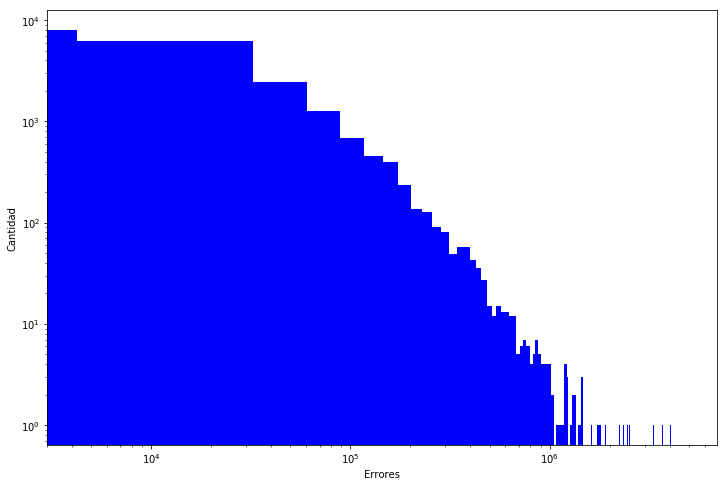

In [14]:
# the histogram of the data
plt.figure(figsize=(12,8))
plt.hist(errores, 500, facecolor='blue')
plt.xlabel('Errores')
plt.ylabel('Cantidad')
#plt.xlim(-1000, 1000) #para variar el "zoom a 0"
plt.yscale('log')
plt.xscale('log')
plt.show()

###  Distribucion de precios

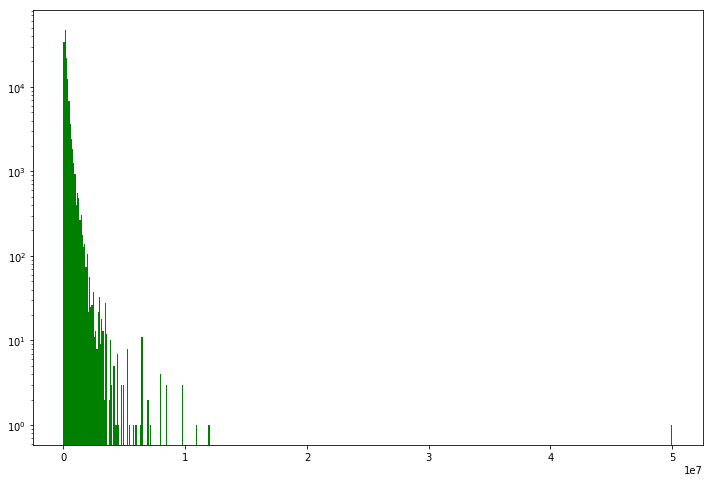

In [148]:
plt.figure(figsize=(12,8))
cant_buckets=500
plt.hist(properati.price_aprox_usd,cant_buckets,facecolor='green')
plt.yscale('log')
plt.show()

# Kaggle

In [ ]:
resultados = mejor_rf.predict(test)
result=pd.DataFrame({'id':test_samples['id'],'price_usd':resultados})
result.to_csv('datos/resultados.csv',index=False)